# Tiền xử lí

In [50]:
import cv2
import os
from keras.callbacks import ModelCheckpoint

In [51]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

In [3]:
def extract_faces_from_image(image_path, output_path, face_count):
    print(f"Processing image: {image_path}")
    img = cv2.imread(image_path)
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)
    for (x, y, w, h) in faces:
        face = cv2.resize(img[y+1:y+h-1, x+1:x+w-1], (128, 128))
        face_count += 1
        cv2.imwrite(f'{output_path}/face_{face_count}.jpg', face)
    return face_count

In [4]:
def extract_faces_from_video(video_path, output_path, face_count):
    print(f"Processing video: {video_path}")
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Can't open {video_path}")
        return face_count

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        faces = face_cascade.detectMultiScale(frame, scaleFactor=1.3, minNeighbors=5)
        for (x, y, w, h) in faces:
            roi = cv2.resize(frame[y+1:y+h-1, x+1:x+w-1], (128, 128))
            face_count += 1
            cv2.imwrite(f'{output_path}/face_{face_count}.jpg', roi)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    return face_count

In [5]:
def process_data_directory(data_path):
    for category in os.listdir(data_path):
        if category != '.DS_Store':
            category_path = os.path.join(data_path, category)
            face_count = 0
            output_path = category_path.replace('dataRaw', 'dataset')
            
            os.makedirs(output_path, exist_ok=True)

            for data_item in os.listdir(category_path):
                if data_item != '.DS_Store':
                    item_path = os.path.join(category_path, data_item)

                    if item_path.endswith('.mp4'):
                        face_count = extract_faces_from_video(item_path, output_path, face_count)

                    if item_path.endswith(('.jpg', '.png', '.jpeg')):
                        face_count = extract_faces_from_image(item_path, output_path, face_count)

            print(f"Total faces in {category}: {face_count}")

In [ ]:
# Process training and testing data directories
data_train_path = 'dataRaw/train_data'
data_test_path = 'dataRaw/test_data'

process_data_directory(data_train_path)
process_data_directory(data_test_path)

# Huấn luyện mô hình

In [82]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image

In [83]:
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# In thông tin chi tiết về GPU (nếu có)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        print("GPU Device Name:", device.name)
else:
    print("Không tìm thấy GPU.")

# In thông tin chi tiết về GPU sử dụng TensorFlow
print("GPU Device Name used by TensorFlow:", tf.test.gpu_device_name())
print(tf.random.normal([10,10]))

Number of GPUs Available:  0
Không tìm thấy GPU.
GPU Device Name used by TensorFlow: 
tf.Tensor(
[[ 0.4073156   0.6281209  -0.725649    1.8125808   1.9386866  -0.82911414
  -0.9974232   0.17550531 -1.7769959  -0.57376456]
 [-0.46623567 -0.83560884  0.8242957   0.51201826  0.7274102   1.2364928
   0.1924735  -0.59252095  1.0271459  -0.03699538]
 [ 1.4064332  -1.4154736   0.92158026  0.80120814 -0.3485854  -1.078021
  -0.03907659 -1.5897696  -0.72069126 -0.31879848]
 [ 0.62490004 -0.21813063 -2.7099068  -1.1111493   0.28738242 -0.63439006
  -0.13984752  1.1882654   0.20203835  0.3157174 ]
 [-0.27766803  0.21807532  1.5575001   0.3105883   0.89358747 -0.5180492
  -2.353296   -0.2551778  -0.9811003   0.17898457]
 [-1.2314595   0.21743377 -0.5062279   0.13686368  0.54572284 -0.88187206
   1.2074231  -1.6319784   0.63582367  0.967463  ]
 [-2.0473504  -0.7698599  -0.49605283  0.7229051  -0.79918844  0.07087464
  -0.6099631   1.4787481   1.2547396  -0.7448372 ]
 [-1.2917072   2.0481808  -1.453

In [84]:
TRAIN_DATA = 'dataset/train_data'
TEST_DATA = 'dataset/test_data'

In [85]:
classes = []

# Lists to store data for training and testing
xtrain = []
ytrain = []
xtest = []
ytest = []

# Dictionary to map class names to labels
dictionary = {}
np.random.seed(5)

In [86]:
#Get Dictionary from Data
class Dictionary:
    def __init__(self, path):
        self.path = path
        self.dictionary = {}
    def operate(self):
        number = 0
        for name in os.listdir(self.path):
            if not name.startswith('.'):
                self.dictionary[name] = number
                number += 1
        return self.dictionary

In [87]:
# Example debugging in the Data class
class Data:
    def __init__(self, path, dictionary):
        self.path = path
        self.dictionary = dictionary
        self.input = []
        self.label = []
        self.listData = []

    def getData(self):
        for whatever in os.listdir(self.path):
            if whatever != '.DS_Store':
                label = whatever
                whatever_path = os.path.join(self.path, whatever)
                list_data_filename_path = []
                
                for filename in os.listdir(whatever_path):
                    if filename != '.DS_Store':
                        filename_path = os.path.join(whatever_path, filename)
                        if filename_path.endswith(('.jpg', '.png', '.jpeg')):
                            img = np.array(Image.open(filename_path))
                            list_data_filename_path.append((img, self.dictionary[label]))

                self.listData.extend(list_data_filename_path)
        return self.listData

    def operate(self):
        self.listData = self.getData()
        np.random.shuffle(self.listData)
        for Data in self.listData:
            self.input.append(np.array(Data[0])) 
            self.label.append(Data[1])
        return self.input, self.label

In [88]:
dictionary = Dictionary(TRAIN_DATA).operate()
classes = list(dictionary.keys())
print(dictionary)

{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '43': 38, '44': 39, '45': 40, '46': 41, '47': 42, '48': 43, '49': 44, '5': 45, '6': 46, '7': 47, '8': 48, '9': 49}


In [89]:
print(os.listdir('dataset/train_data'))

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '6', '7', '8', '9']


In [90]:
# Example usage with debugging
xtrain, list_train = Data(TRAIN_DATA, dictionary).operate()
xtest, list_test = Data(TEST_DATA, dictionary).operate()

In [91]:
print(len(xtrain))
print(len(xtest))

2898
699


In [92]:
# Normalize data to the range [0, 1]
xtrain, xtest = np.array(xtrain) / 100, np.array(xtest) / 100

# Expand dimensions for the channel (3 for RGB)
ytrain, ytest = np.array([np.expand_dims(item, axis=0) for item in list_train]), np.array([np.expand_dims(item, axis=0) for item in list_test])

# Convert labels to one-hot encoding
ytrain_ohe, ytest_ohe = to_categorical(ytrain), to_categorical(ytest)

# Tạo mô hình mạng CNN

Mô hình nhận các tham số đầu vào là:
- num_filters1, num_filters2, num_filters3: Số lượng bộ lọc (filters) cho các lớp Conv2D tương ứng. Các lớp Conv2D giúp mô hình học các đặc trưng cấp thấp và cấp cao từ ảnh đầu vào.Các giá trị mặc định là 32, 64 và 128.
- dense_units:Số lượng đơn vị trong lớp Dense, nơi mà thông tin từ các đặc trưng đã được học được kết hợp để thực hiện phân loại.
Giá trị mặc định là 512.
- dropout_rate: Tỷ lệ dropout, nơi mà một phần các đơn vị sẽ bị tắt ngẫu nhiên trong quá trình đào tạo để tránh overfitting.
Giá trị mặc định là 0.5, tức là 50% của các đơn vị sẽ bị tắt.
- 'relu' được sử dụng cho các lớp Conv2D và Dense để giúp mô hình học các đặc trưng phi tuyến tính.
- 'softmax' được sử dụng ở lớp đầu ra để chuyển đổi đầu ra thành xác suất, thích hợp cho bài toán phân loại nhiều lớp.
input_shape:

Mô hình này sử dụng loạt các lớp Conv2D để học các đặc trưng từ ảnh, sau đó giảm kích thước của đầu ra thông qua lớp MaxPool2D. Sau đó, thông qua các lớp Dense, mô hình học cách kết hợp các đặc trưng này để thực hiện phân loại. BatchNormalization và Dropout được sử dụng để cải thiện tổng quát hóa và giảm overfitting.

In [93]:
def build_cnn_model(num_filters1=32, num_filters2=64, num_filters3=128, dense_units=512, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(num_filters1, (3, 3), input_shape=(112, 112, 4), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(num_filters2, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(num_filters3, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D((2, 2)),
        layers.Dropout(dropout_rate),

        layers.Conv2D(num_filters3, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D((2, 2)),
        layers.Dropout(dropout_rate),
        
        layers.Conv2D(num_filters3, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool2D((2, 2)),
        layers.Dropout(dropout_rate),
        
        layers.Flatten(),
        layers.Dense(dense_units*2, activation='relu'),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(len(classes), activation='softmax')
    ])
    return model  # Thêm dòng này để trả về mô hình từ hàm


In [94]:
model_cnn_1 = build_cnn_model(num_filters1=32, num_filters2=64, num_filters3=128, dense_units=512, dropout_rate=0.4)
model_cnn_2 = build_cnn_model(num_filters1=64, num_filters2=128, num_filters3=256, dense_units=1024, dropout_rate=0.4)
model_cnn_3 = build_cnn_model(num_filters1=128, num_filters2=256, num_filters3=512, dense_units=1024, dropout_rate=0.3)


In [96]:
model_cnn_1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
history1 = model_cnn_1.fit(xtrain,ytrain_ohe,epochs=10,validation_data=(xtest,ytest_ohe))

Epoch 1/10
91/91 [==============================] - 53s 569ms/step - loss: 3.9886 - accuracy: 0.0328 - val_loss: 4.0458 - val_accuracy: 0.0200
Epoch 2/10
91/91 [==============================] - 56s 620ms/step - loss: 3.7430 - accuracy: 0.0638 - val_loss: 4.3591 - val_accuracy: 0.0272
Epoch 3/10
91/91 [==============================] - 70s 767ms/step - loss: 3.4784 - accuracy: 0.1097 - val_loss: 5.5791 - val_accuracy: 0.0300
Epoch 4/10
91/91 [==============================] - 71s 782ms/step - loss: 3.2107 - accuracy: 0.1622 - val_loss: 5.9372 - val_accuracy: 0.0472
Epoch 5/10
91/91 [==============================] - 71s 783ms/step - loss: 2.9514 - accuracy: 0.2008 - val_loss: 4.6350 - val_accuracy: 0.1144
Epoch 6/10
91/91 [==============================] - 69s 757ms/step - loss: 2.6732 - accuracy: 0.2712 - val_loss: 3.2322 - val_accuracy: 0.2074
Epoch 7/10
91/91 [==============================] - 80s 865ms/step - loss: 2.3622 - accuracy: 0.3406 - val_loss: 5.7283 - val_accuracy: 0.0844

In [97]:
model_cnn_2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
history2 = model_cnn_2.fit(xtrain,ytrain_ohe,epochs=10,validation_data=(xtest,ytest_ohe))

Epoch 1/10
91/91 [==============================] - 193s 2s/step - loss: 3.9644 - accuracy: 0.0487 - val_loss: 4.1982 - val_accuracy: 0.0200
Epoch 2/10
91/91 [==============================] - 197s 2s/step - loss: 3.5191 - accuracy: 0.0963 - val_loss: 5.3887 - val_accuracy: 0.0443
Epoch 3/10
91/91 [==============================] - 192s 2s/step - loss: 3.1078 - accuracy: 0.1739 - val_loss: 6.6623 - val_accuracy: 0.0372
Epoch 4/10
91/91 [==============================] - 188s 2s/step - loss: 2.6627 - accuracy: 0.2781 - val_loss: 4.2010 - val_accuracy: 0.0615
Epoch 5/10
91/91 [==============================] - 188s 2s/step - loss: 2.2912 - accuracy: 0.3596 - val_loss: 8.1707 - val_accuracy: 0.0472
Epoch 6/10
91/91 [==============================] - 192s 2s/step - loss: 1.9394 - accuracy: 0.4507 - val_loss: 3.8427 - val_accuracy: 0.1931
Epoch 7/10
91/91 [==============================] - 191s 2s/step - loss: 1.6786 - accuracy: 0.5335 - val_loss: 1.8995 - val_accuracy: 0.4835
Epoch 8/10
91

In [98]:
model_cnn_3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
history3 = model_cnn_3.fit(xtrain,ytrain_ohe,epochs=10,validation_data=(xtest,ytest_ohe))

Epoch 1/10
91/91 [==============================] - 491s 5s/step - loss: 3.9992 - accuracy: 0.0521 - val_loss: 4.3896 - val_accuracy: 0.0329
Epoch 2/10
91/91 [==============================] - 492s 5s/step - loss: 3.3460 - accuracy: 0.1373 - val_loss: 5.6155 - val_accuracy: 0.0443
Epoch 3/10
91/91 [==============================] - 508s 6s/step - loss: 2.7865 - accuracy: 0.2450 - val_loss: 8.2659 - val_accuracy: 0.0458
Epoch 4/10
91/91 [==============================] - 501s 6s/step - loss: 2.2090 - accuracy: 0.3775 - val_loss: 11.9682 - val_accuracy: 0.0243
Epoch 5/10
91/91 [==============================] - 506s 6s/step - loss: 1.6828 - accuracy: 0.5110 - val_loss: 5.6619 - val_accuracy: 0.1202
Epoch 6/10
91/91 [==============================] - 505s 6s/step - loss: 1.3449 - accuracy: 0.5983 - val_loss: 1.7145 - val_accuracy: 0.5479
Epoch 7/10
91/91 [==============================] - 505s 6s/step - loss: 0.9985 - accuracy: 0.6994 - val_loss: 2.4178 - val_accuracy: 0.4649
Epoch 8/10
9

In [103]:
model_cnn_1.save("./model1.h5")
model_cnn_2.save("./model2.h5")
model_cnn_3.save("./model3.h5")

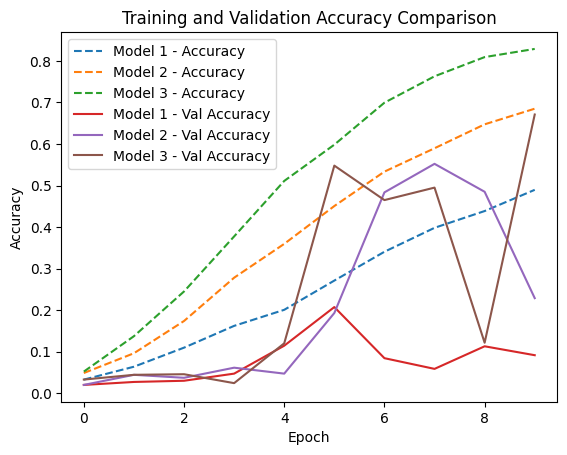

In [99]:
# Biểu đồ cho accuracy
plt.plot(history1.history['accuracy'], label='Model 1 - Accuracy', linestyle='dashed')
plt.plot(history2.history['accuracy'], label='Model 2 - Accuracy', linestyle='dashed')
plt.plot(history3.history['accuracy'], label='Model 3 - Accuracy', linestyle='dashed')

# Biểu đồ cho val_accuracy
plt.plot(history1.history['val_accuracy'], label='Model 1 - Val Accuracy')
plt.plot(history2.history['val_accuracy'], label='Model 2 - Val Accuracy')
plt.plot(history3.history['val_accuracy'], label='Model 3 - Val Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Comparison')
plt.show()

# Test

Cụ thể, đồ thị cho thấy:
Mô hình 1 có độ chính xác cao nhất trong quá trình đào tạo, đạt khoảng 0,95 sau 8 epoch.
Mô hình 2 có độ chính xác thấp hơn một chút so với mô hình 1, đạt khoảng 0,9 sau 8 epoch.
Mô hình 3 có độ chính xác thấp nhất, đạt khoảng 0,85 sau 8 epoch.

In [108]:
# Tải lại mô hình từ trọng số đã lưu
# model_cnn_3.load_weights(checkpoint_path_3)
load_model = tf.keras.models.load_model("./model3.h5")

In [109]:
xtrain, list_train = Data(TRAIN_DATA, dictionary).operate()
xtest, list_test = Data(TEST_DATA, dictionary).operate()
xtrain, xtest = np.array(xtrain)/100, np.array(xtest)/100
ytrain, ytest = np.array([np.expand_dims(item, axis=0) for item in list_train]), np.array([np.expand_dims(item, axis=0) for item in list_test])
classes = list(dictionary.keys())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 214ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 74ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 59ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 58ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 65ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 66ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 59ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 64ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 67ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 68ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 65ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 74ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 64ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 58ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 67ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 65ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 68ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 70ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 69ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 64ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 72ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 70ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 67ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 65ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 65ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 65ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 64ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 66ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 105ms/step
39


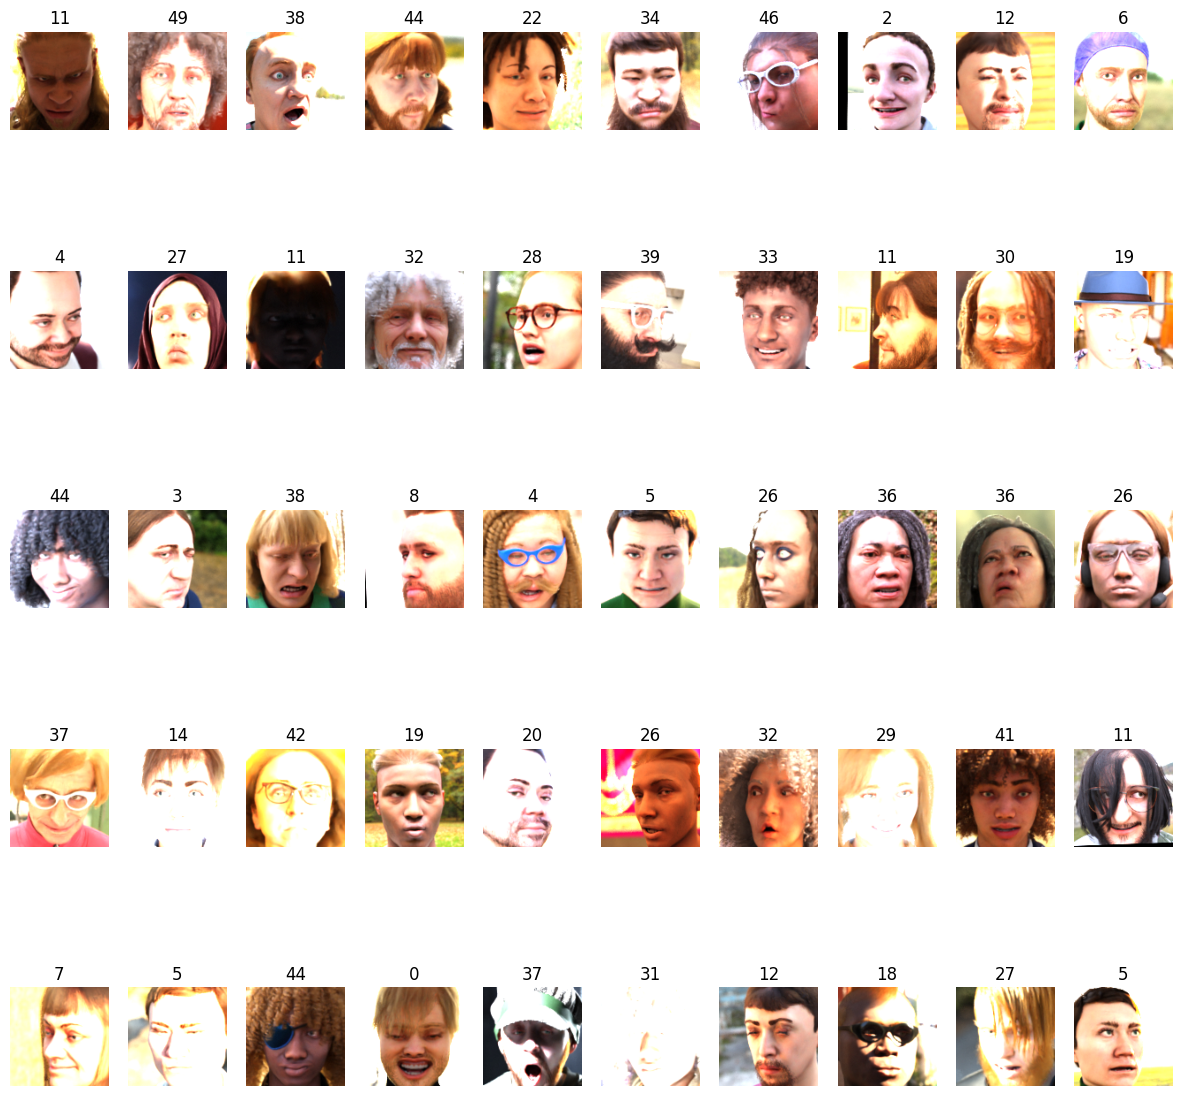

In [110]:
acc = 0
fig = plt.figure(figsize=(15,15))
for i in range(50):
    plt.subplot(5,10,i+1)
    #Vì dataset/train chưa đủ lớn, đa dạng nên để xtest thì tỷ lệ đúng ít, thử thay xtest, ytest thành xtrain, ytrain (tỉ lệ đúng khá cao)
    plt.imshow(xtest[i])
    result = np.argmax(load_model.predict(xtest[i].reshape((-1,112,112,4))))
    if result == ytest[i][0]:
        acc +=1
    plt.title(classes[result])
    plt.grid(color='lightgray', linestyle='--')
    plt.axis("off")

print(acc)
plt.show()